# Titanic Survival Prediction

This notebook implements a classification analysis using four tree-based models:
1. Decision Tree Classifier
2. Random Forest Classifier
3. AdaBoost Classifier
4. XGBoost Classifier

## 1. Library Imports and Initial Setup

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
from xgboost import plot_tree as xgplot_tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             average_precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             auc, classification_report)

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2.1 Data Loading and Initial Exploration

In [2]:
# Load the Titanic dataset
df = pd.read_csv('https://raw.githubusercontent.com/Mariptime/CS4372-Assignments/refs/heads/main/Datasets/A2-Titanic-Dataset.csv')
print("Dataset Shape:", df.shape)


Dataset Shape: (891, 12)


In [3]:
print("\nFirst Few Rows:")
df.head()



First Few Rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("\nData Types:")
df.dtypes


Data Types:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Check for missing values
print("Missing Values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})

missing_df[missing_df['Missing_Count'] > 0]


Missing Values:


,Missing_Count,Percentage
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467


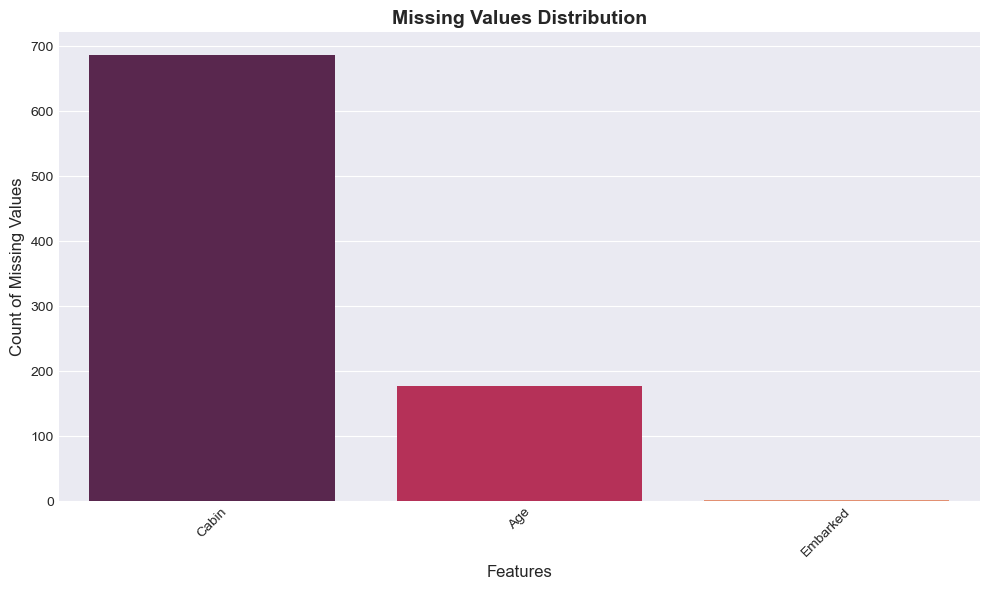


Target Variable (Survived) Distribution:
Survived
0    549
1    342
Name: count, dtype: int64

Target Variable Proportions:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [7]:
# Visualize missing data
fig, ax = plt.subplots(figsize=(10, 6))
missing_df_sorted = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
sns.barplot(x=missing_df_sorted.index, y=missing_df_sorted['Missing_Count'], ax=ax, palette='rocket')
ax.set_title('Missing Values Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Count of Missing Values', fontsize=12)
ax.set_xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTarget Variable (Survived) Distribution:")
print(df['Survived'].value_counts())
print("\nTarget Variable Proportions:")
print(df['Survived'].value_counts(normalize=True))

In [8]:
# Handle missing values
print("Handling missing values...\n")

# Age: Fill with median
print(f"Age: Filled {df['Age'].isnull().sum()} missing values with median")
df['Age'].fillna(df['Age'].median(), inplace=True)

# Cabin: Drop or impute - here we'll drop due to high missing rate
print("Cabin: Dropped due to 77% missing values")
df.drop('Cabin', axis=1, inplace=True)

# Embarked: Fill with mode
print(f"Embarked: Filled {df['Embarked'].isnull().sum()} missing values with mode")
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop PassengerId (not useful for prediction) and Name (too many unique values)
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

print("\nFinal dataset shape after handling missing values:", df.shape)
print("\nRemaining missing values:")
print(df.isnull().sum().sum())

Handling missing values...

Age: Filled 177 missing values with median
Cabin: Dropped due to 77% missing values
Embarked: Filled 2 missing values with mode

Final dataset shape after handling missing values: (891, 8)

Remaining missing values:
0


In [9]:
# Display feature information
print("Feature Analysis")
print("Numerical Features:")
df.describe()

Feature Analysis
Numerical Features:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
print("\nCategorical Features:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}: {df[col].unique()}")
    print(f"Value counts:\n{df[col].value_counts()}")


Categorical Features:

Sex: ['male' 'female']
Value counts:
Sex
male      577
female    314
Name: count, dtype: int64

Embarked: ['S' 'C' 'Q']
Value counts:
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [11]:
# Encode categorical variables
print("Encoding categorical variables...\n")

# Sex: Binary encoding (Male=1, Female=0)
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
print("Sex: Encoded as binary (male=1, female=0)")

# Embarked: One-hot encoding
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)
df = pd.concat([df, embarked_dummies], axis=1)
df.drop('Embarked', axis=1, inplace=True)
print("Embarked: One-hot encoded")

df.head()

Encoding categorical variables...

Sex: Encoded as binary (male=1, female=0)
Embarked: One-hot encoded


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True


In [12]:
print("\nFinal shape:", df.shape)
print("\nData types:")
print(df.dtypes)


Final shape: (891, 9)

Data types:
Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_Q       bool
Embarked_S       bool
dtype: object


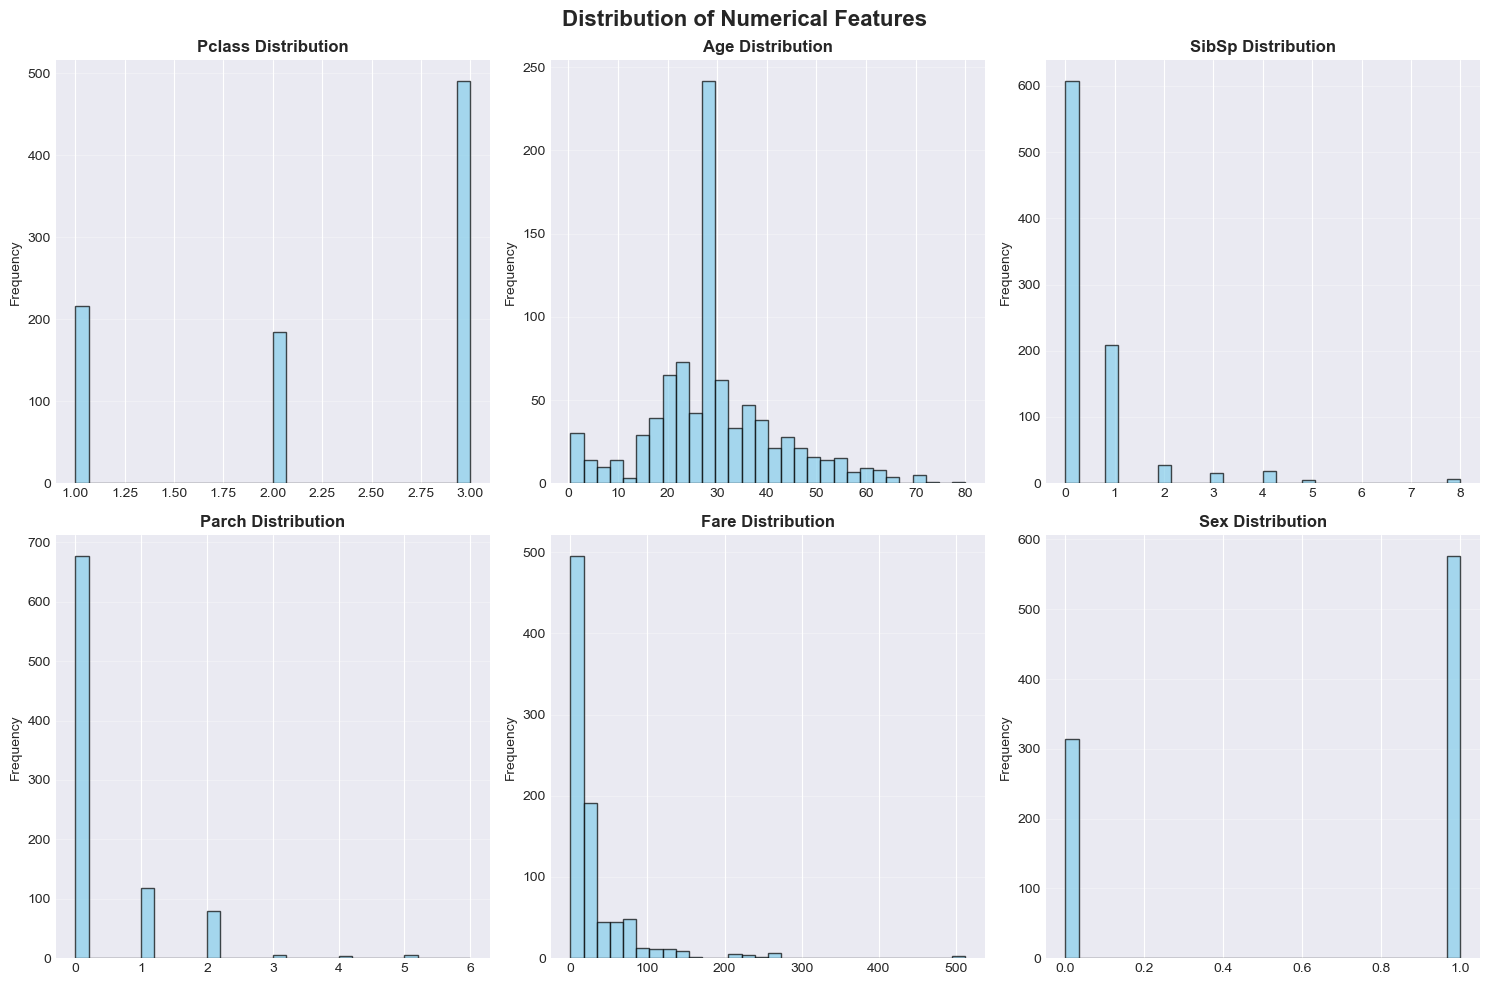

In [13]:
# Feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']
for idx, feature in enumerate(numerical_features):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[feature], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.set_title(f'{feature} Distribution', fontweight='bold')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("Feature Distribution Analysis:")
for feature in numerical_features:
    print(f"\n{feature}:")
    print(f"  Skewness: {df[feature].skew():.3f}")
    print(f"  Kurtosis: {df[feature].kurtosis():.3f}")

Feature Distribution Analysis:

Pclass:
  Skewness: -0.631
  Kurtosis: -1.280

Age:
  Skewness: 0.510
  Kurtosis: 0.994

SibSp:
  Skewness: 3.695
  Kurtosis: 17.880

Parch:
  Skewness: 2.749
  Kurtosis: 9.778

Fare:
  Skewness: 4.787
  Kurtosis: 33.398

Sex:
  Skewness: -0.619
  Kurtosis: -1.621


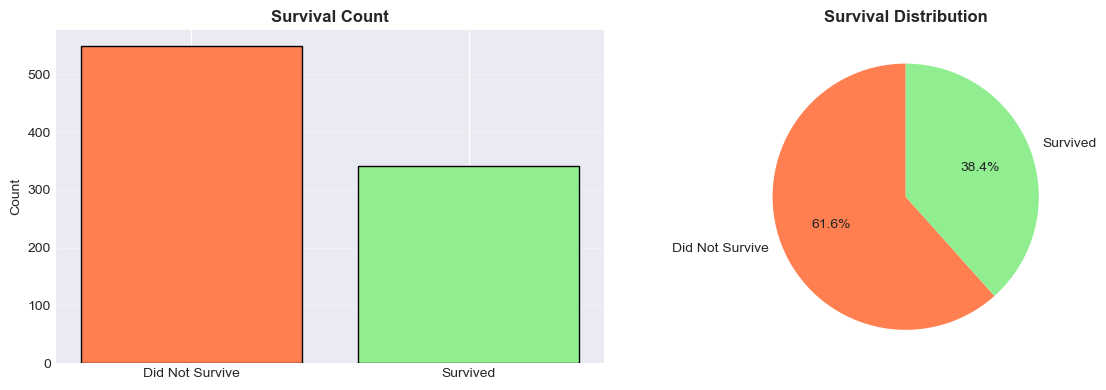

Class Distribution:
Did Not Survive: 549 (61.6%)
Survived: 342 (38.4%)

Class Balance Ratio: 1.61


In [15]:
# Target variable analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
survival_counts = df['Survived'].value_counts()
axes[0].bar(['Did Not Survive', 'Survived'], survival_counts.values, color=['coral', 'lightgreen'], edgecolor='black')
axes[0].set_title('Survival Count', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
survival_pct = df['Survived'].value_counts(normalize=True) * 100
axes[1].pie(survival_pct.values, labels=['Did Not Survive', 'Survived'], autopct='%1.1f%%',
            colors=['coral', 'lightgreen'], startangle=90)
axes[1].set_title('Survival Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Class Distribution:")
print(f"Did Not Survive: {survival_counts[0]} ({survival_pct[0]:.1f}%)")
print(f"Survived: {survival_counts[1]} ({survival_pct[1]:.1f}%)")
print(f"\nClass Balance Ratio: {survival_counts[0] / survival_counts[1]:.2f}")

Correlation Analysis:

Correlation with Survival:
Survived      1.000000
Fare          0.257307
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.149683
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64


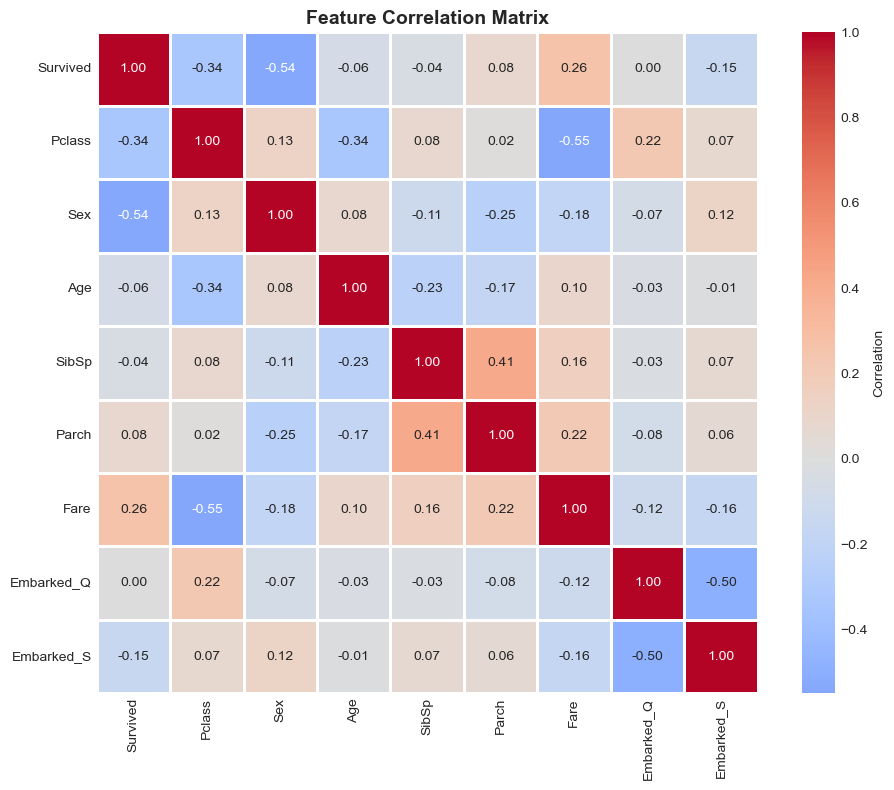

In [16]:
# Correlation analysis
print("Correlation Analysis:\n")

# Correlation with target variable
correlation_with_target = df.corr()['Survived'].sort_values(ascending=False)
print("Correlation with Survival:")
print(correlation_with_target)

# Heatmap of correlations
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

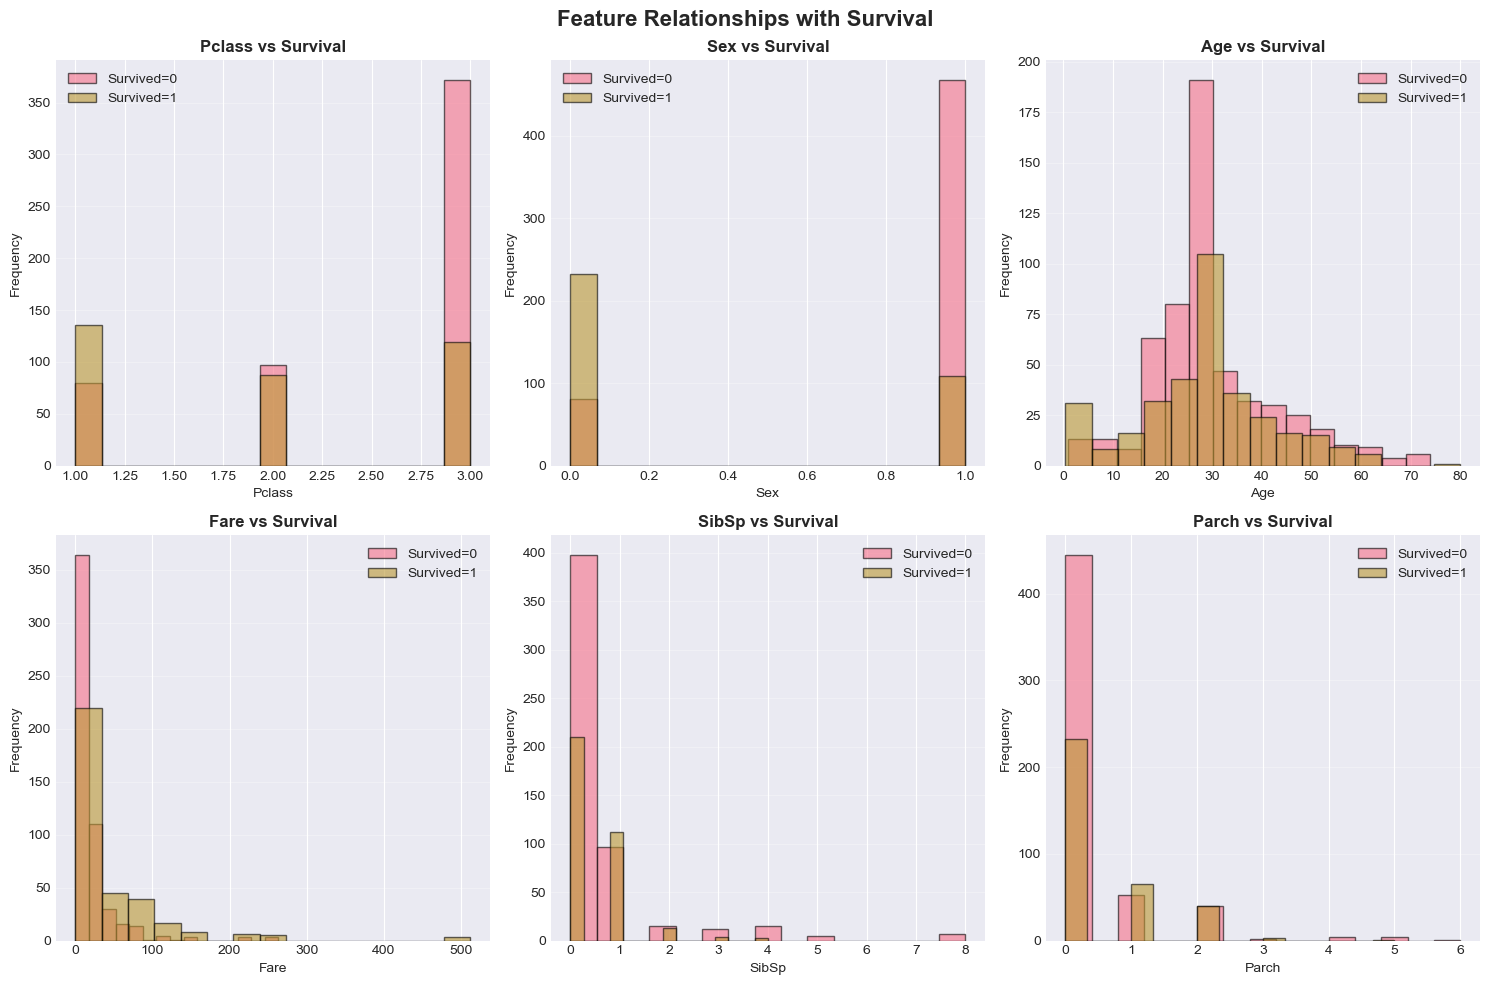

In [17]:
# Relationship between features and survival
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Relationships with Survival', fontsize=16, fontweight='bold')

features_to_plot = ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    for survived in [0, 1]:
        data = df[df['Survived'] == survived][feature]
        ax.hist(data, alpha=0.6, label=f'Survived={survived}', bins=15, edgecolor='black')
    
    ax.set_title(f'{feature} vs Survival', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Check for Feature Importance
X = df.drop('Survived', axis=1)
y = df['Survived']

print("Features (X):", X.columns.tolist())
print("Target (y):", y.name)
print(f"\nShape - X: {X.shape}, y: {y.shape}")

# Quick feature importance using a simple Decision Tree
dt_quick = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_quick.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_quick.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree with max_depth=5):")
print(feature_importance)

Features (X): ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
Target (y): Survived

Shape - X: (891, 8), y: (891,)

Feature Importance (Decision Tree with max_depth=5):
      Feature  Importance
1         Sex    0.554502
0      Pclass    0.188272
5        Fare    0.102399
2         Age    0.098497
3       SibSp    0.039613
7  Embarked_S    0.008899
4       Parch    0.007817
6  Embarked_Q    0.000000


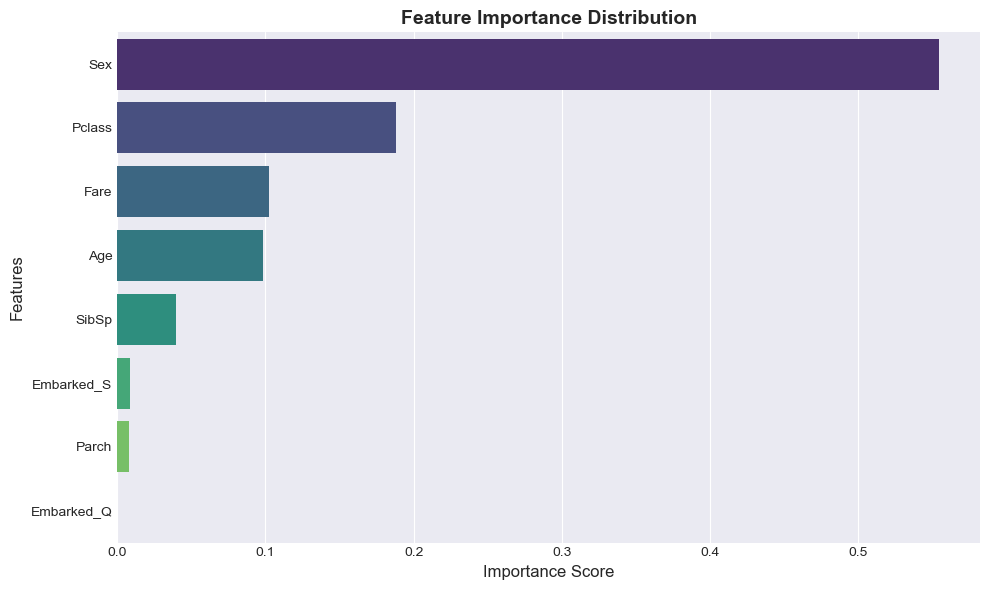


Important features (importance > 0.05): ['Sex', 'Pclass', 'Fare', 'Age']
Number of important features: 4 out of 8


In [19]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis', ax=ax)
ax.set_title('Feature Importance Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Select important features (threshold > 0.05)
important_features = feature_importance[feature_importance['Importance'] > 0.05]['Feature'].tolist()
print(f"\nImportant features (importance > 0.05): {important_features}")
print(f"Number of important features: {len(important_features)} out of {len(X.columns)}")

In [20]:
# Use all features for comprehensive analysis
X_full = X.copy()
y_full = y.copy()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_full)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_full)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 712 (79.9%)
Testing set size: 179 (20.1%)

Training set class distribution:
Survived
0    439
1    273
Name: count, dtype: int64

Testing set class distribution:
Survived
0    110
1     69
Name: count, dtype: int64


In [21]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data standardization completed.")
print(f"\nMean of scaled training features (should be ~0): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Std of scaled training features (should be ~1): {X_train_scaled.std(axis=0)[:5]}")

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Data standardization completed.

Mean of scaled training features (should be ~0): [-1.82126474e-16 -9.97953281e-18  2.12065072e-16 -5.61348720e-18
 -1.62167408e-17]
Std of scaled training features (should be ~1): [1. 1. 1. 1. 1.]


## 2.2 + 2.3 Model Construction and Tree Vizualization

### Decision Tree Classifier with GridSearchCV

In [22]:
print("="*80)
print("MODEL 1: DECISION TREE CLASSIFIER WITH GRIDSEARCHCV")
print("="*80)

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

print(f"\nParameter grid for Decision Tree:")
for key, value in dt_param_grid.items():
    print(f"  {key}: {value}")
print(f"\nTotal combinations: {np.prod([len(v) for v in dt_param_grid.values()])}")

MODEL 1: DECISION TREE CLASSIFIER WITH GRIDSEARCHCV

Parameter grid for Decision Tree:
  max_depth: [3, 5, 7, 10, 15, 20, None]
  min_samples_split: [2, 5, 10, 20]
  min_samples_leaf: [1, 2, 4, 8]
  criterion: ['gini', 'entropy']

Total combinations: 224


In [23]:
# Create base Decision Tree
dt_base = DecisionTreeClassifier(random_state=42)

# GridSearchCV
dt_grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=dt_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nPerforming GridSearchCV for Decision Tree...")
dt_grid_search.fit(X_train_scaled, y_train)
print("\nGridSearchCV completed!")

# Best parameters and score
print(f"\nBest parameters: {dt_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {dt_grid_search.best_score_:.4f}")


Performing GridSearchCV for Decision Tree...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

GridSearchCV completed!

Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best cross-validation ROC-AUC score: 0.8525


In [24]:
# Get best model
dt_model = dt_grid_search.best_estimator_

# Make predictions
dt_y_pred_train = dt_model.predict(X_train_scaled)
dt_y_pred_test = dt_model.predict(X_test_scaled)
dt_y_pred_proba_test = dt_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
dt_train_acc = accuracy_score(y_train, dt_y_pred_train)
dt_test_acc = accuracy_score(y_test, dt_y_pred_test)
dt_test_precision = precision_score(y_test, dt_y_pred_test)
dt_test_recall = recall_score(y_test, dt_y_pred_test)
dt_test_f1 = f1_score(y_test, dt_y_pred_test)
dt_test_roc_auc = roc_auc_score(y_test, dt_y_pred_proba_test)

print("\n" + "="*50)
print("DECISION TREE - PERFORMANCE METRICS")
print("="*50)
print(f"Training Accuracy: {dt_train_acc:.4f}")
print(f"Test Accuracy: {dt_test_acc:.4f}")
print(f"Test Precision: {dt_test_precision:.4f}")
print(f"Test Recall: {dt_test_recall:.4f}")
print(f"Test F1-Score: {dt_test_f1:.4f}")
print(f"Test ROC-AUC: {dt_test_roc_auc:.4f}")

# Store metrics for comparison
dt_metrics = {
    'Model': 'Decision Tree',
    'Train_Accuracy': dt_train_acc,
    'Test_Accuracy': dt_test_acc,
    'Precision': dt_test_precision,
    'Recall': dt_test_recall,
    'F1_Score': dt_test_f1,
    'ROC_AUC': dt_test_roc_auc
}


DECISION TREE - PERFORMANCE METRICS
Training Accuracy: 0.8244
Test Accuracy: 0.7877
Test Precision: 0.7627
Test Recall: 0.6522
Test F1-Score: 0.7031
Test ROC-AUC: 0.8177


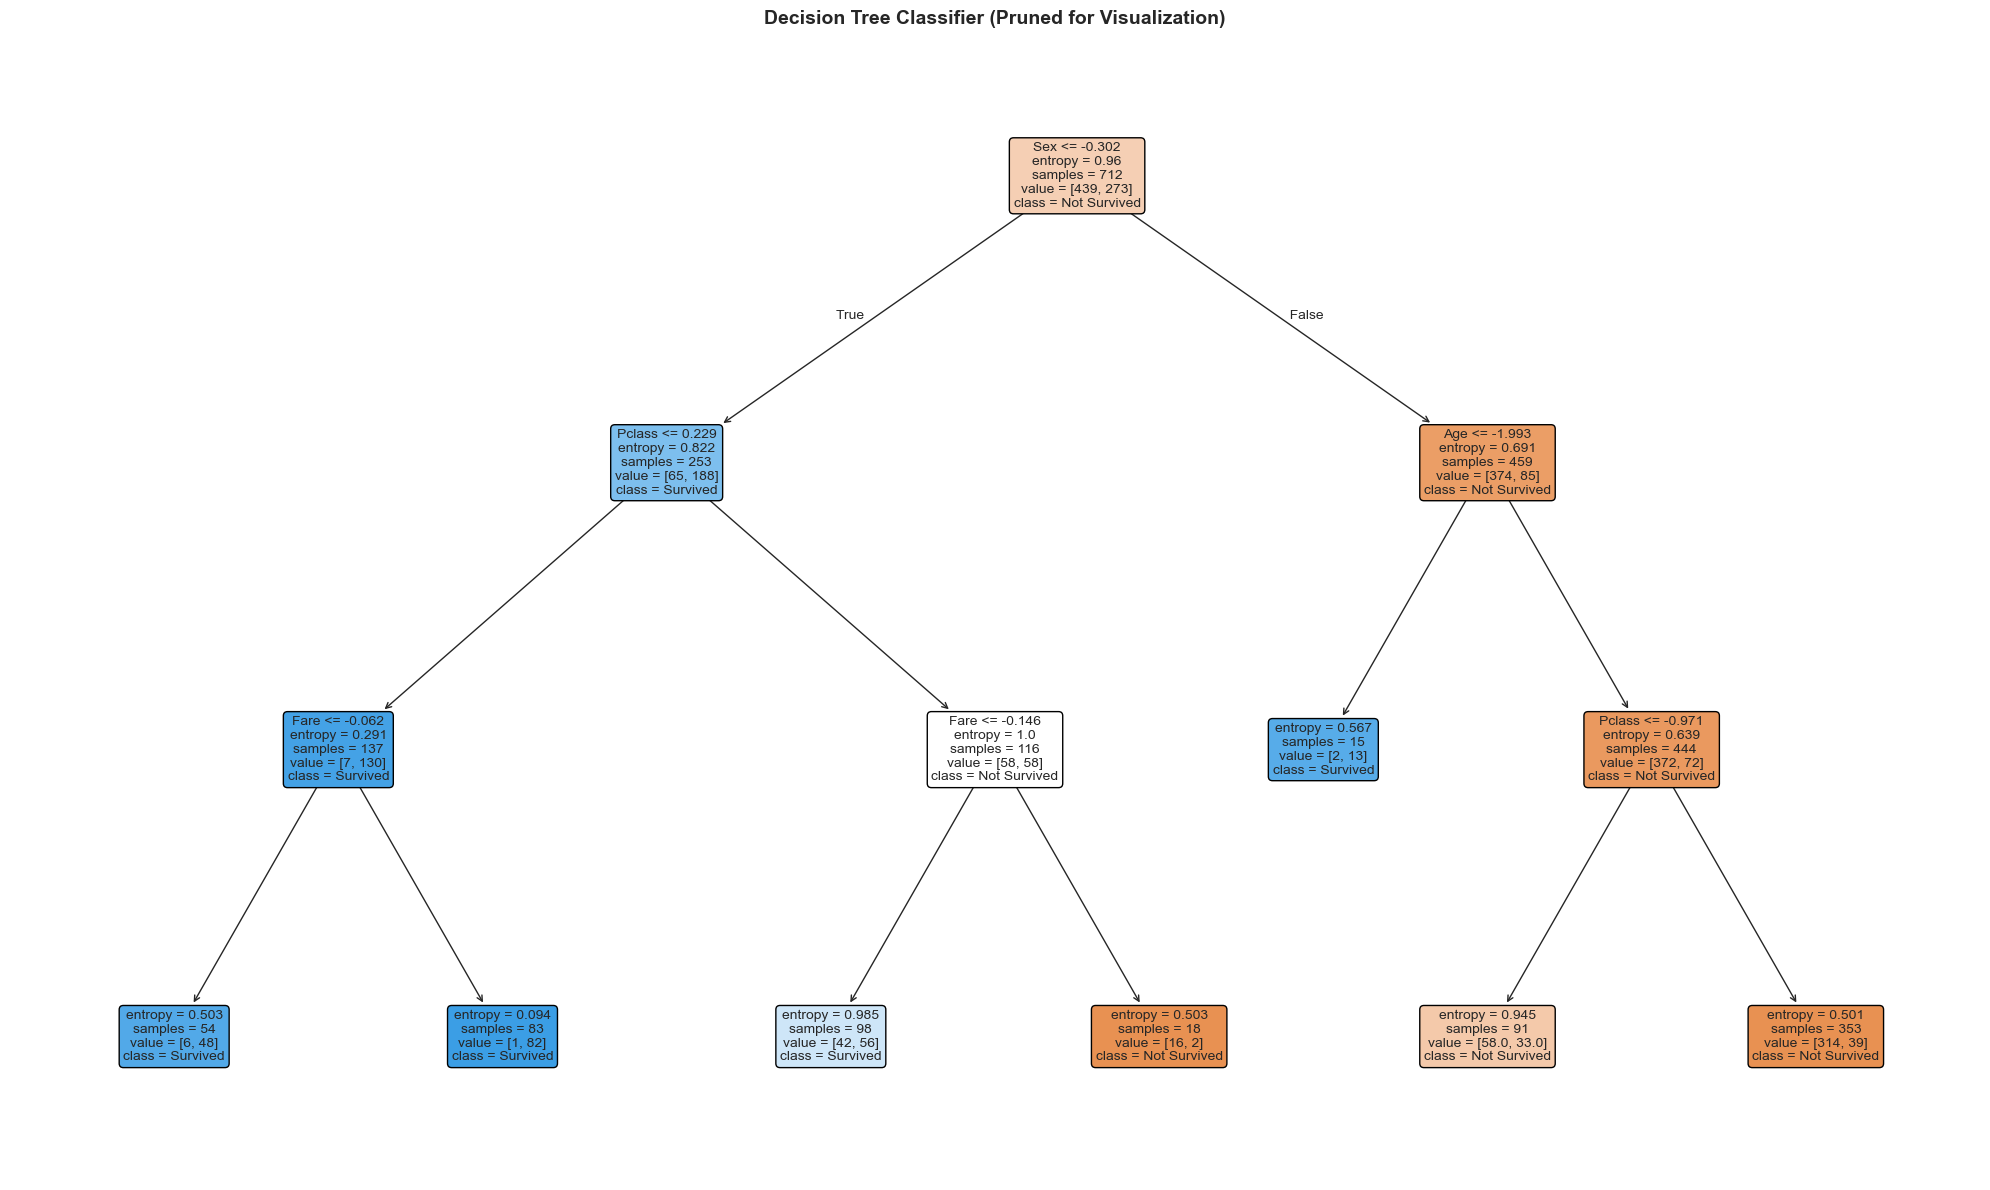

Tree depth: 3
Number of leaves: 7


In [25]:
# Visualize the Decision Tree
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'],
          filled=True, rounded=True, fontsize=10, ax=ax)
ax.set_title('Decision Tree Classifier (Pruned for Visualization)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

### Random Forest Classifier with GridSearchCV

In [26]:
print("\n" + "="*80)
print("MODEL 2: RANDOM FOREST CLASSIFIER WITH GRIDSEARCHCV")
print("="*80)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"\nParameter grid for Random Forest:")
for key, value in rf_param_grid.items():
    print(f"  {key}: {value}")
print(f"\nTotal combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")


MODEL 2: RANDOM FOREST CLASSIFIER WITH GRIDSEARCHCV

Parameter grid for Random Forest:
  n_estimators: [50, 100, 200, 300]
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

Total combinations: 360


In [27]:
# Create base Random Forest
rf_base = RandomForestClassifier(random_state=42)

# GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nPerforming GridSearchCV for Random Forest...")
rf_grid_search.fit(X_train_scaled, y_train)
print("\nGridSearchCV completed!")

# Best parameters and score
print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {rf_grid_search.best_score_:.4f}")


Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

GridSearchCV completed!

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation ROC-AUC score: 0.8782


Random Forest metrics:
Train_Accuracy: 0.8890
Test_Accuracy: 0.8101
Precision: 0.8302
Recall: 0.6377
F1_Score: 0.7213
ROC_AUC: 0.8368


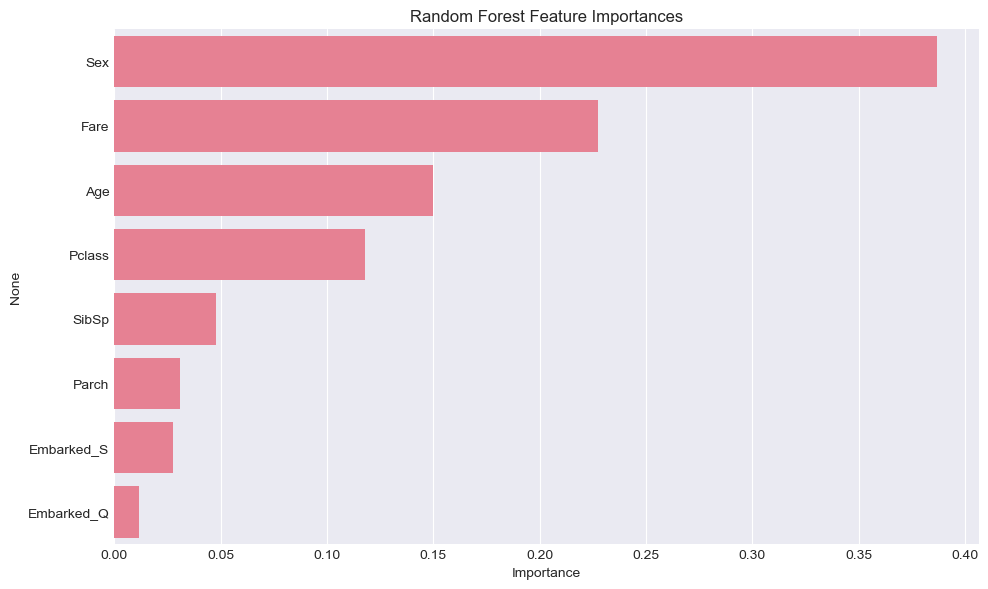

In [28]:

# Get best Random Forest model from GridSearch
rf_model = rf_grid_search.best_estimator_

# Predictions
rf_y_pred_train = rf_model.predict(X_train_scaled)
rf_y_pred_test = rf_model.predict(X_test_scaled)
rf_y_pred_proba_test = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics

rf_train_acc = accuracy_score(y_train, rf_y_pred_train)
rf_test_acc = accuracy_score(y_test, rf_y_pred_test)
rf_test_precision = precision_score(y_test, rf_y_pred_test)
rf_test_recall = recall_score(y_test, rf_y_pred_test)
rf_test_f1 = f1_score(y_test, rf_y_pred_test)
rf_test_roc_auc = roc_auc_score(y_test, rf_y_pred_proba_test)

rf_metrics = {
    'Model': 'Random Forest',
    'Train_Accuracy': rf_train_acc,
    'Test_Accuracy': rf_test_acc,
    'Precision': rf_test_precision,
    'Recall': rf_test_recall,
    'F1_Score': rf_test_f1,
    'ROC_AUC': rf_test_roc_auc
}

print("Random Forest metrics:")
for k, v in rf_metrics.items():
    if k != 'Model':
        print(f"{k}: {v:.4f}")

# Feature importance visualization
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


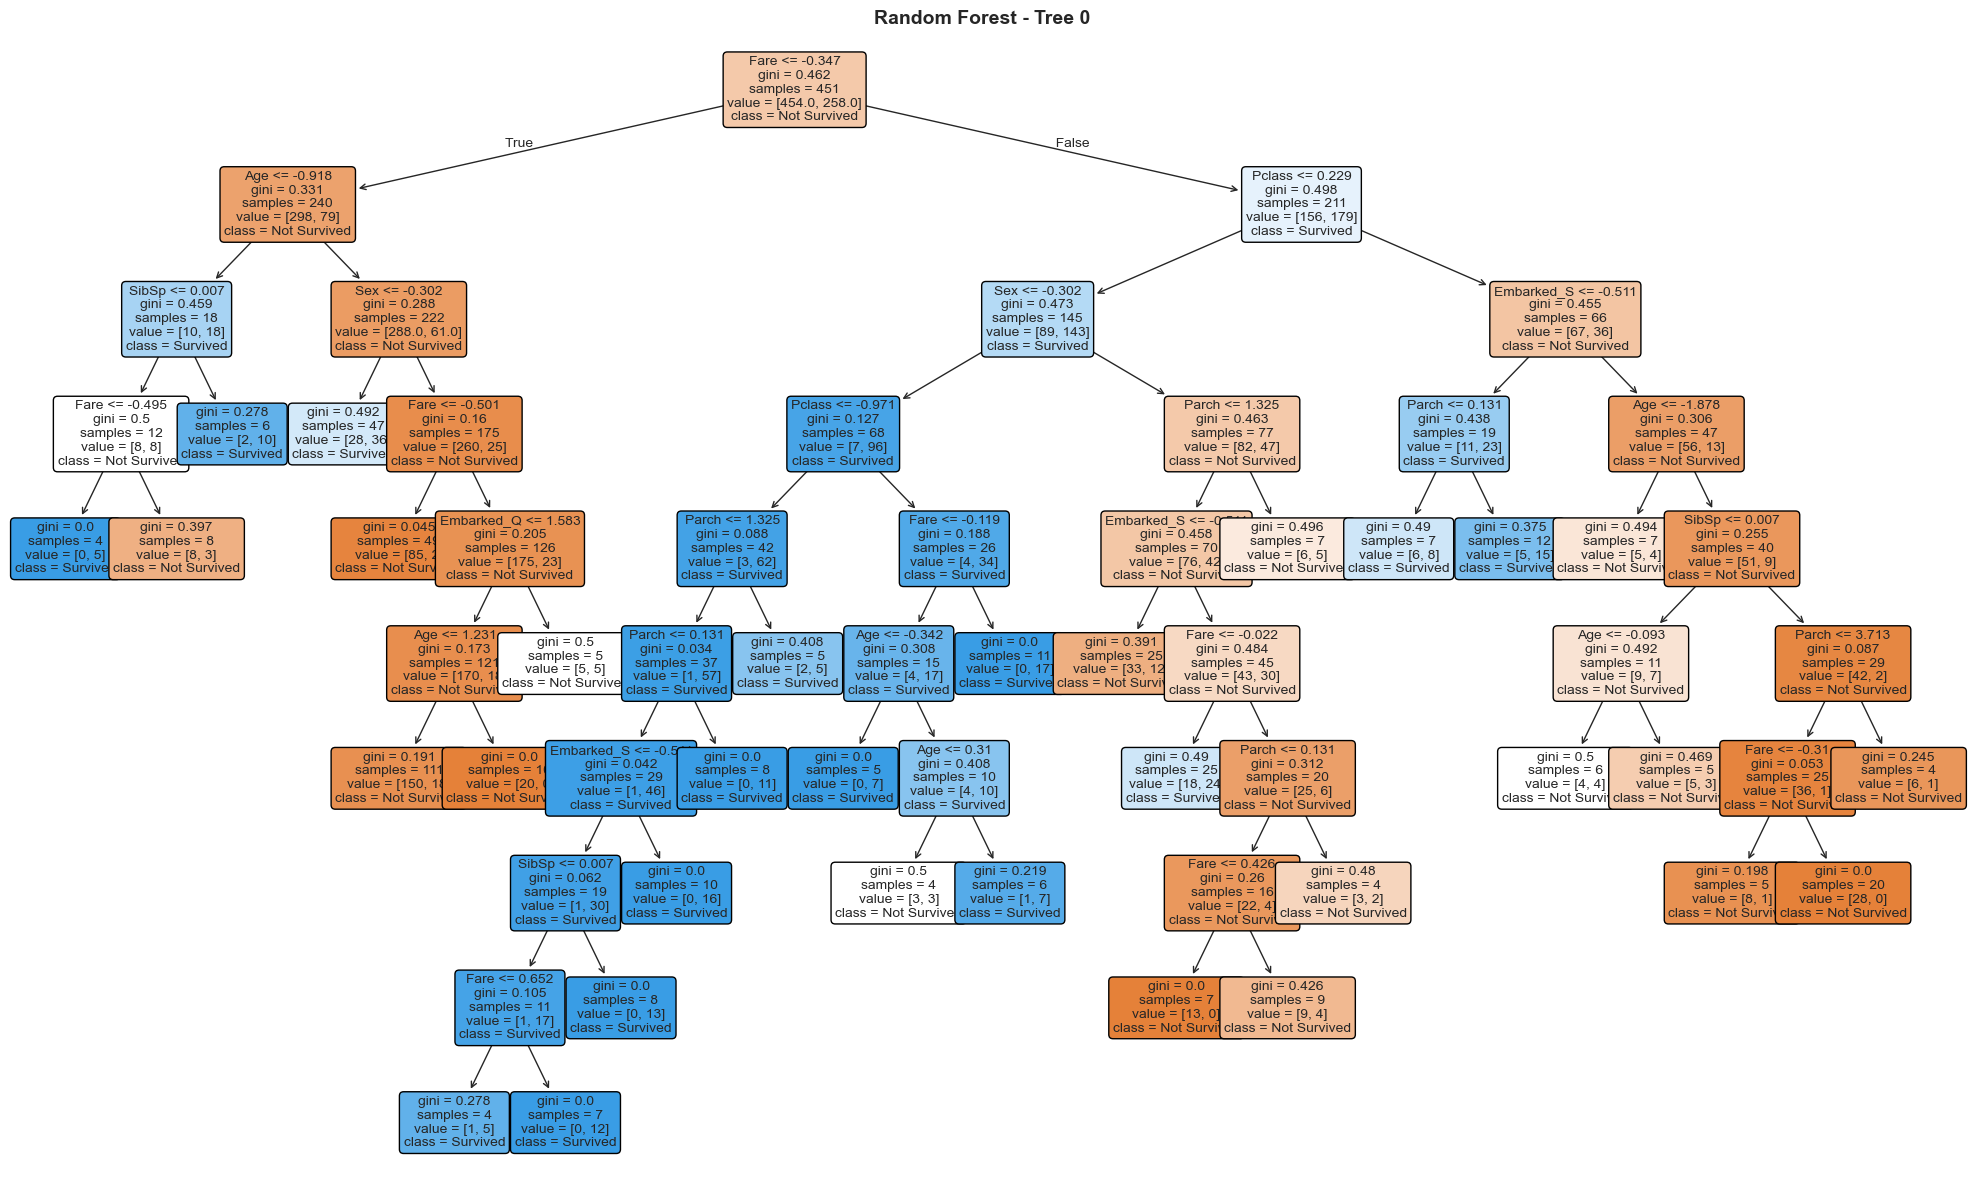

In [29]:
# Visualize one of the trees in the Random Forest
tree_index = 0  # Index of the tree to visualize
rf_tree = rf_model.estimators_[tree_index]

fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(rf_tree, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'],
          filled=True, rounded=True, fontsize=10, ax=ax)
ax.set_title(f'Random Forest - Tree {tree_index}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### AdaBoost Classifier with GridSearchCV

Fitting AdaBoost with GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Completed AdaBoost GridSearch. Best params: {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost metrics:
Train_Accuracy: 0.8778
Test_Accuracy: 0.7933
Precision: 0.7667
Recall: 0.6667
F1_Score: 0.7132
ROC_AUC: 0.7945


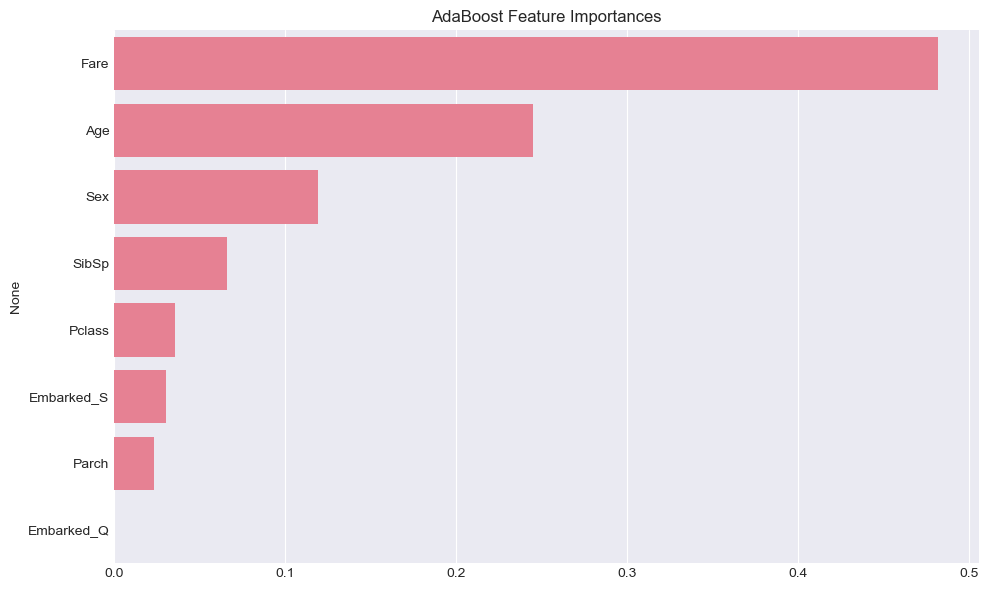

In [30]:

ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Use DecisionTreeClassifier as base estimator
from sklearn.tree import DecisionTreeClassifier
ada_base = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Wrap with GridSearchCV
from sklearn.model_selection import GridSearchCV
ada_grid = GridSearchCV(ada_base, param_grid=ada_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

print("Fitting AdaBoost with GridSearchCV...")
ada_grid.fit(X_train_scaled, y_train)
print("Completed AdaBoost GridSearch. Best params:", ada_grid.best_params_)

# Best model & predictions
ada_model = ada_grid.best_estimator_
ada_y_pred_train = ada_model.predict(X_train_scaled)
ada_y_pred_test = ada_model.predict(X_test_scaled)
ada_y_pred_proba_test = ada_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
ada_train_acc = accuracy_score(y_train, ada_y_pred_train)
ada_test_acc = accuracy_score(y_test, ada_y_pred_test)
ada_test_precision = precision_score(y_test, ada_y_pred_test)
ada_test_recall = recall_score(y_test, ada_y_pred_test)
ada_test_f1 = f1_score(y_test, ada_y_pred_test)
ada_test_roc_auc = roc_auc_score(y_test, ada_y_pred_proba_test)

ada_metrics = {
    'Model': 'AdaBoost',
    'Train_Accuracy': ada_train_acc,
    'Test_Accuracy': ada_test_acc,
    'Precision': ada_test_precision,
    'Recall': ada_test_recall,
    'F1_Score': ada_test_f1,
    'ROC_AUC': ada_test_roc_auc
}

print("AdaBoost metrics:")
for k, v in ada_metrics.items():
    if k != 'Model':
        print(f"{k}: {v:.4f}")

# Feature importance (aggregate of base estimators is not straightforward, but we can use feature_importances_ if available)
try:
    if hasattr(ada_model, 'feature_importances_'):
        imp = pd.Series(ada_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=imp.values, y=imp.index)
        plt.title("AdaBoost Feature Importances")
        plt.tight_layout()
        plt.show()
    else:
        print("AdaBoost model does not expose feature_importances_. Skipping plot.")
except Exception as e:
    print("Error plotting AdaBoost importances:", e)


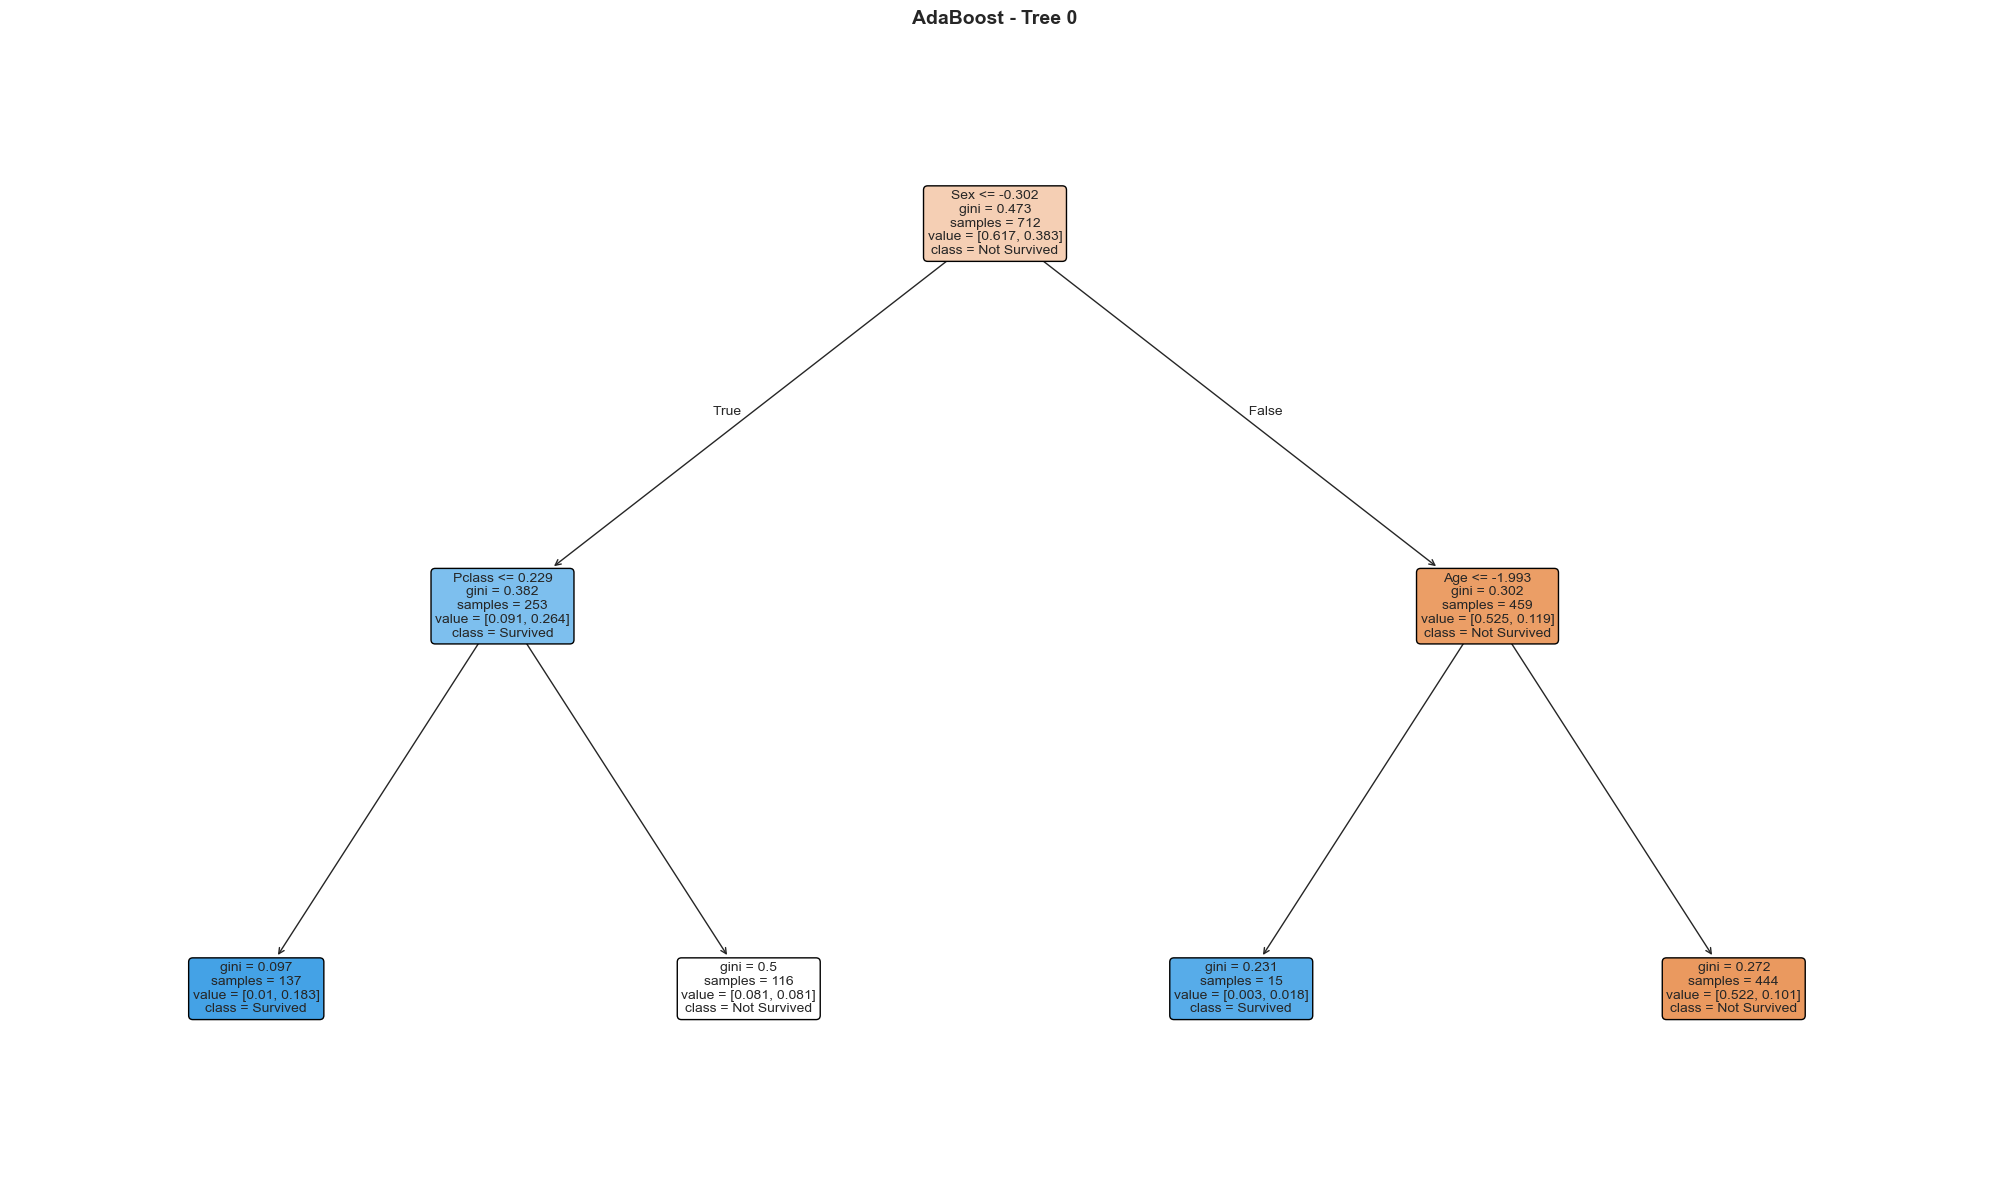

In [31]:
# Visualize one of the trees in the AdaBoost ensemble
tree_index = 0  # Index of the tree to visualize
ada_tree = ada_model.estimators_[tree_index]

fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(ada_tree, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'],
          filled=True, rounded=True, fontsize=10, ax=ax)
ax.set_title(f'AdaBoost - Tree {tree_index}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### XGBoost Classifier with GridSearchCV

Fitting XGBoost with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Completed XGBoost GridSearch. Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost metrics:
Train_Accuracy: 0.9129
Test_Accuracy: 0.7877
Precision: 0.7541
Recall: 0.6667
F1_Score: 0.7077
ROC_AUC: 0.8041


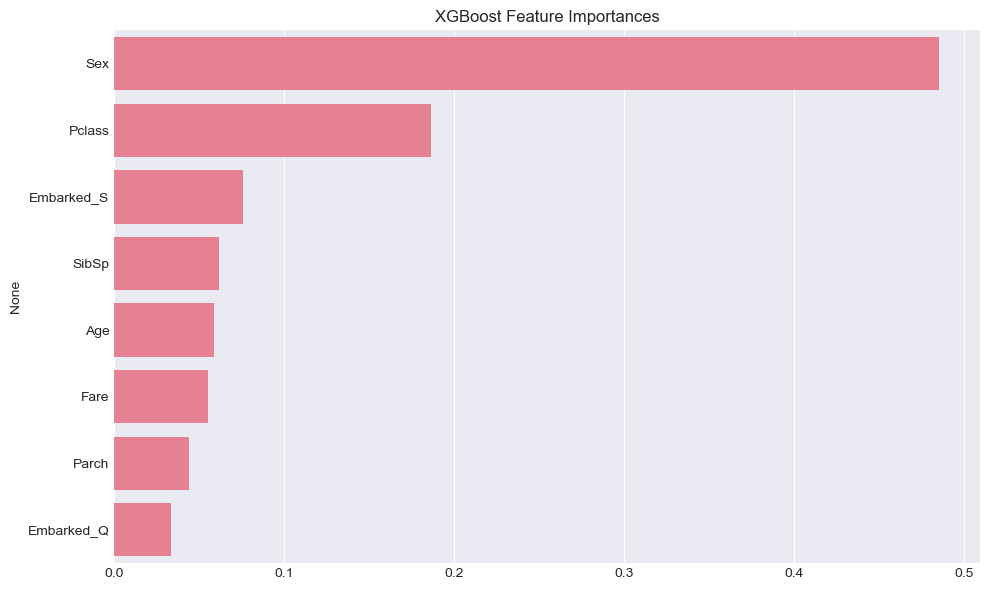

In [32]:

# XGBoost GridSearch
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_grid = GridSearchCV(xgb_base, param_grid=xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
print("Fitting XGBoost with GridSearchCV...")
xgb_grid.fit(X_train_scaled, y_train)
print("Completed XGBoost GridSearch. Best params:", xgb_grid.best_params_)

xgb_model = xgb_grid.best_estimator_
xgb_y_pred_train = xgb_model.predict(X_train_scaled)
xgb_y_pred_test = xgb_model.predict(X_test_scaled)
xgb_y_pred_proba_test = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
xgb_train_acc = accuracy_score(y_train, xgb_y_pred_train)
xgb_test_acc = accuracy_score(y_test, xgb_y_pred_test)
xgb_test_precision = precision_score(y_test, xgb_y_pred_test)
xgb_test_recall = recall_score(y_test, xgb_y_pred_test)
xgb_test_f1 = f1_score(y_test, xgb_y_pred_test)
xgb_test_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba_test)

xgb_metrics = {
    'Model': 'XGBoost',
    'Train_Accuracy': xgb_train_acc,
    'Test_Accuracy': xgb_test_acc,
    'Precision': xgb_test_precision,
    'Recall': xgb_test_recall,
    'F1_Score': xgb_test_f1,
    'ROC_AUC': xgb_test_roc_auc
}

print("XGBoost metrics:")
for k, v in xgb_metrics.items():
    if k != 'Model':
        print(f"{k}: {v:.4f}")

# Feature importance
try:
    imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title("XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Error plotting XGBoost importances:", e)


<Figure size 2000x1000 with 0 Axes>

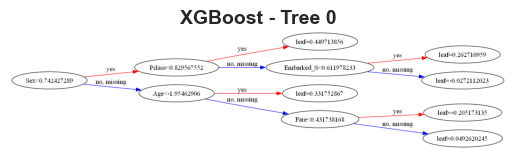

In [33]:
# Visualize one of the trees in the XGBoost model (XGboost has its own tree plotting function)
plt.figure(figsize=(20, 10))
xgplot_tree(xgb_model, num_trees=tree_index, rankdir='LR')  # tree_index is the index of the tree to visualize
plt.title(f"XGBoost - Tree {tree_index}", fontsize=14, fontweight='bold')
plt.show()

## 2.4 Result Analysis

### Confusion Matrix

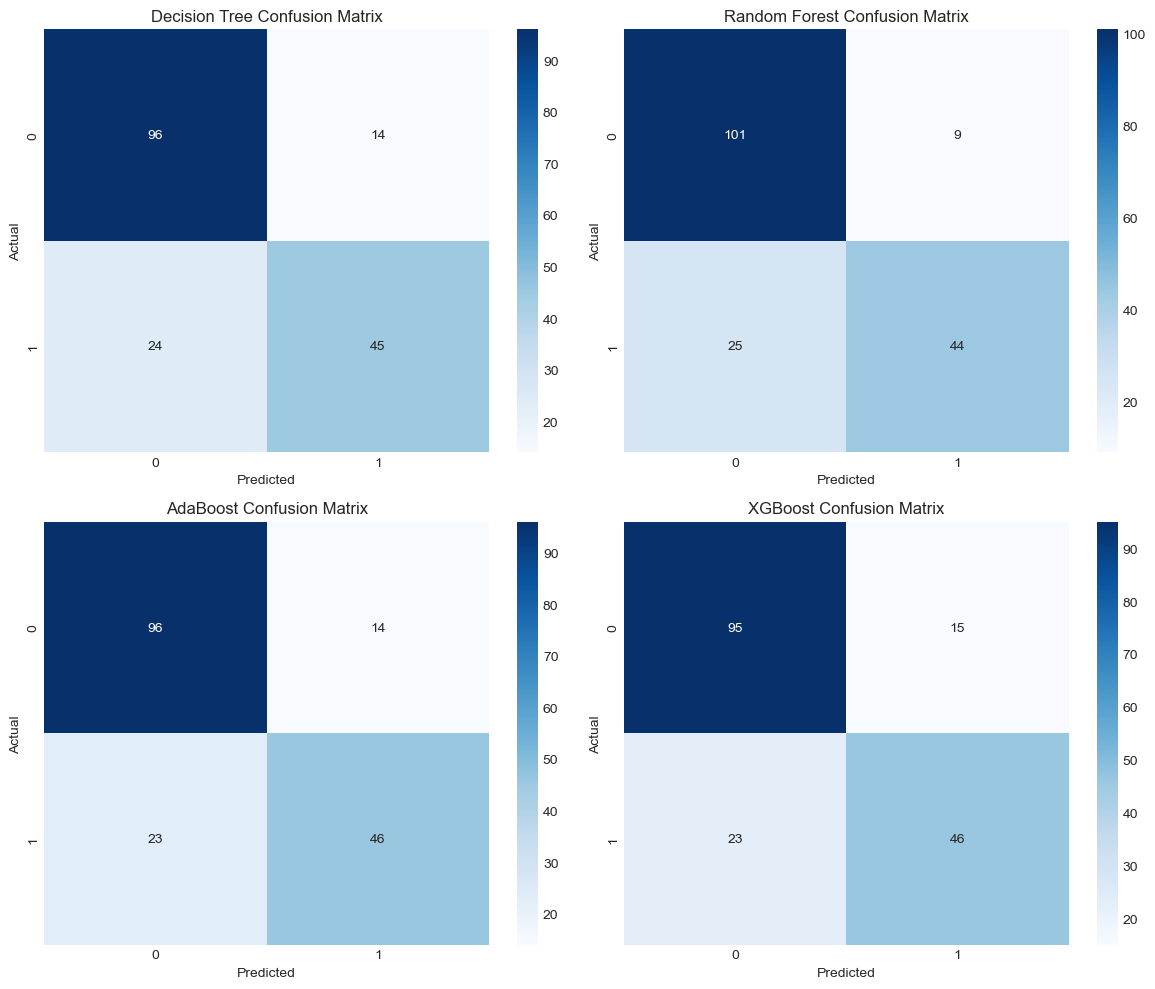

In [34]:

models = {
    'Decision Tree': (dt_model, dt_y_pred_test),
    'Random Forest': (rf_model, rf_y_pred_test),
    'AdaBoost': (ada_model, ada_y_pred_test),
    'XGBoost': (xgb_model, xgb_y_pred_test)
}

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.ravel()

for i, (name, (model, y_pred)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### ROC Curves

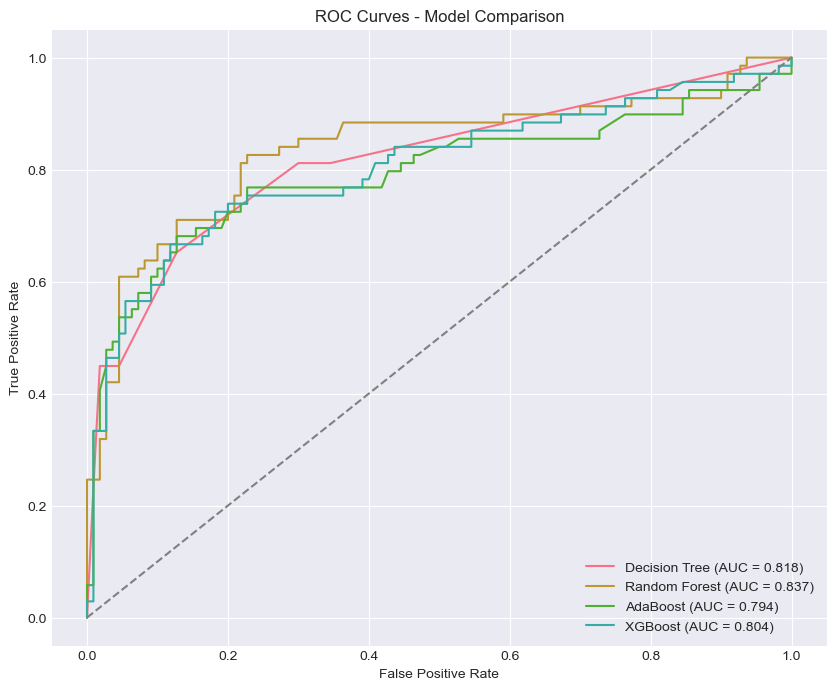

In [35]:

plt.figure(figsize=(10,8))

model_probs = {
    'Decision Tree': dt_y_pred_proba_test,
    'Random Forest': rf_y_pred_proba_test,
    'AdaBoost': ada_y_pred_proba_test,
    'XGBoost': xgb_y_pred_proba_test
}

for name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Precision-Recall Curves

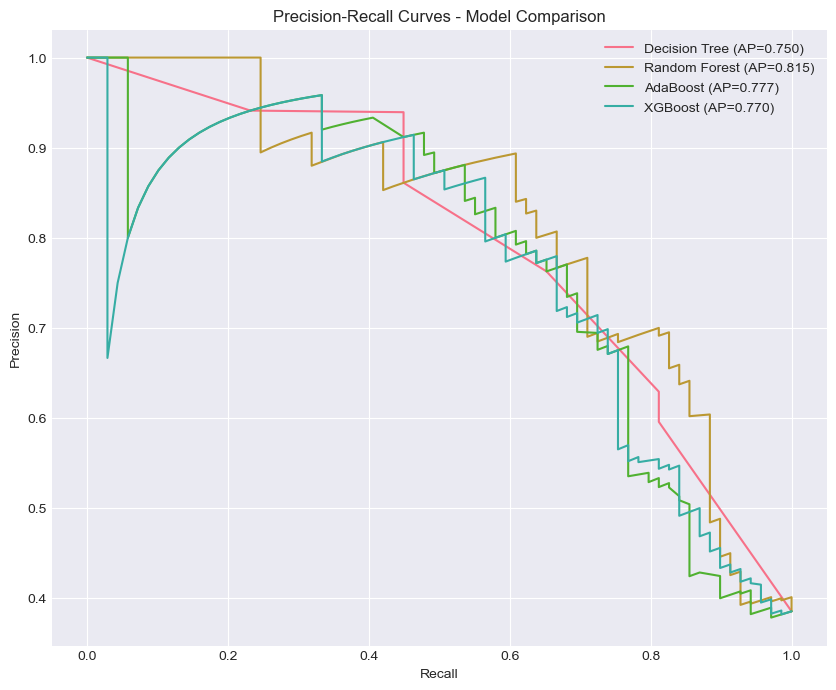

In [36]:

plt.figure(figsize=(10,8))

for name, probs in model_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### Metrics Comparison Table

In [37]:

# Combine metrics into DataFrame
metrics_df = pd.DataFrame([dt_metrics, rf_metrics, ada_metrics, xgb_metrics]).set_index('Model')
metrics_df


,Train_Accuracy,Test_Accuracy,Precision,Recall,F1_Score,ROC_AUC
Model,,,,,,
Decision Tree,0.824438,0.787709,0.762712,0.652174,0.703125,0.817655
Random Forest,0.889045,0.810056,0.830189,0.637681,0.721311,0.836759
AdaBoost,0.877809,0.793296,0.766667,0.666667,0.713178,0.794466
XGBoost,0.912921,0.787709,0.754098,0.666667,0.707692,0.804084


### Classification Reports

In [38]:


print("Decision Tree Classification Report:\n", classification_report(y_test, dt_y_pred_test))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred_test))
print("AdaBoost Classification Report:\n", classification_report(y_test, ada_y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_y_pred_test))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       110
           1       0.83      0.64      0.72        69

    accuracy                           0.81       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179

AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       

### Cross-Validation Analysis (5-fold)

In [39]:

models_for_cv = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'AdaBoost': ada_model,
    'XGBoost': xgb_model
}

cv_results = {}
for name, model in models_for_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name} CV ROC-AUC scores: {scores.round(4)} | Mean: {scores.mean():.4f} | Std: {scores.std():.4f}")

# Display as DataFrame
cv_df = pd.DataFrame(cv_results)
cv_df


Decision Tree CV ROC-AUC scores: [0.8423 0.8243 0.8639 0.8675 0.8643] | Mean: 0.8525 | Std: 0.0167
Random Forest CV ROC-AUC scores: [0.847  0.8541 0.8941 0.9141 0.8814] | Mean: 0.8782 | Std: 0.0249
AdaBoost CV ROC-AUC scores: [0.846  0.847  0.9025 0.8856 0.9015] | Mean: 0.8765 | Std: 0.0252
XGBoost CV ROC-AUC scores: [0.8574 0.8338 0.9041 0.9038 0.9061] | Mean: 0.8811 | Std: 0.0299


,Decision Tree,Random Forest,AdaBoost,XGBoost
0,0.842252,0.847004,0.845971,0.857438
1,0.824277,0.854132,0.847004,0.833781
2,0.863950,0.894148,0.902508,0.904075
3,0.867529,0.914141,0.885627,0.903830
4,0.864268,0.881418,0.901515,0.906145


## Contributors
- @mariptime: Akshay Nagarajan
- @vaipos: Vaishnavi Pasumathi